# Snowpark デモ

やっぱり実際動いているものを見るのが一番わかりやすいですよね！
というわけで、Snowpark でデータを操作してみましょう。

※ SnowVillage ライブ時と異なり、提供データの1行がそのまま見えてしまう個所は、出力を削除しています。ご了承ください。

# おしながき

- [Snowpark の基本](#snowpark-の基本)
    - [接続設定](接続設定)
    - [DataFrame の操作](DataFrame-の操作)
    - [UDF とストアドプロシージャ](UDF-とストアドプロシージャ)
- [機械学習](機械学習)
    - [学習とモデルの保存](学習とモデルの保存)
    - [推論](推論)
- [提供データを Snowpark で触ってみよう](提供データを-Snowpark-で触ってみよう)


## Snowpark の基本


### 接続設定
ますはセッションを作成しましょう。
（Snowsight などの Web UI や Snowflake クライアントで接続するときに作成されるセッションと同じ概念です）

In [1]:
# 実行環境へのパスを通す（念のため）
current_path = '/home/dev/'

In [2]:
import sys
# notebook フォルダがパスに入っていないので追加
sys.path.append(current_path)

In [3]:
from snowflake.snowpark.session import Session
from config import connection_parameters

# config.py にはこのようなものが書いてあります：
# connection_parameters = {
#    "account": "xx00000.ap-northeast-1.aws",
#     "user": "<you_username>",
#     "private_key": pkb,
#     "role": "<your_role>",
#     "database": "<your_database>",
#     "schema": "<your_schema>",
#     "warehouse": "<your_warehouse>",
# }

session = Session.builder.configs(connection_parameters).create()

/opt/conda/envs/pysnowpark/lib/python3.8/site-packages/snowflake/connector/options.py:107: UserWarning: You have an incompatible version of 'pyarrow' installed (8.0.0), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(


試しに、現在、使用しているウェアハウス、データベース、スキーマを確認してみましょう。

クエリを実行するには `sql(<クエリ>).collect()` です。`collect()` や `show()` を呼ぶまで実行されないので注意（遅延評価）

In [4]:
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='COMPUTE_WH', CURRENT_DATABASE()='SANDBOX', CURRENT_SCHEMA()='PUBLIC')]


In [5]:
# show() では表形式になる
session.sql('select current_warehouse(), current_database(), current_schema()').show()

---------------------------------------------------------------------
|"CURRENT_WAREHOUSE()"  |"CURRENT_DATABASE()"  |"CURRENT_SCHEMA()"  |
---------------------------------------------------------------------
|COMPUTE_WH             |SANDBOX               |PUBLIC              |
---------------------------------------------------------------------



### DataFrame の操作

それではさっそく Snowpark で Dataframe の操作をしてみましょう。

今回、提供いただいているデータの中から、マインディアさんのデータを見ていきましょう。

こんな感じのデータです。

| カラム名 | 型 | 説明 | 
| :- | :- | :- | 
| AGE | VARCHAR(16777216) | 年代（20～49代） |
| AMOUNT_TO_RATIO | FLOAT | 推定購入値（※）|
| GENDER | VARCHAR(16777216) | 性別（男性/女性) |
| PURCHASE_AREA | VARCHAR(16777216) | 地域<br>（東京23区・大阪市・名古屋市、区ごと） |
| PURCHASE_DATE | DATE  | 購入日 |

※ PURCHASE_DATA、GENDER、AGE、PURCHASE_AREA でグルーピングしたとき、全体平均売上（1とする）に対するグループの売り上げ比率

In [ ]:
df = session.table('MINEDIA_CONTEST.CONTEST.PURCHASE_DELIVERY')
df.limit(10).show()

ちなみに、、、Pandas Dataframe で表示したほうが、綺麗な感じになったりしますが、今回は Snowpark のお話なので、しません！

In [ ]:
import pandas as pd

pd.DataFrame(df.limit(10).collect())
# df.limit(10).to_pandas()

基礎集計を出すこともできます。

In [8]:
df.describe().show()

-----------------------------------------------------------------------
|"SUMMARY"  |"GENDER"  |"AGE"  |"PURCHASE_AREA"  |"AMOUNT_TO_RATIO"   |
-----------------------------------------------------------------------
|count      |17313     |17313  |17313            |17313.0             |
|mean       |NULL      |NULL   |NULL             |1.1830994050713304  |
|stddev     |NULL      |NULL   |NULL             |0.9201612371196348  |
|min        |女性        |20代    |世田谷区             |0.0                 |
|max        |男性        |40代    |足立区              |21.876841467469     |
-----------------------------------------------------------------------



続いて、よくある DataFrame の操作を行ってみましょう。

フィルタリング（SQL でいう Where 句）

In [9]:
import snowflake.snowpark.functions as F


df.where(
    F.col('AMOUNT_TO_RATIO') > 10
).select(
    F.col('PURCHASE_AREA'), F.col('PURCHASE_DATE'), F.col('AMOUNT_TO_RATIO')
).show(50)

---------------------------------------------------------
|"PURCHASE_AREA"  |"PURCHASE_DATE"  |"AMOUNT_TO_RATIO"  |
---------------------------------------------------------
|江東区              |2019-04-03       |21.876841467469    |
|世田谷区             |2019-12-16       |12.410324289843    |
|世田谷区             |2020-08-19       |14.076044622282    |
|江東区              |2020-09-22       |12.361275572344    |
|葛飾区              |2020-10-09       |11.256848859906    |
|江東区              |2020-05-31       |20.705273021596    |
|中央区              |2020-11-29       |10.806918631905    |
|豊島区              |2020-12-04       |10.467979482047    |
---------------------------------------------------------



グルーピング（group by）、集計、ソート（order by）

In [10]:
df.group_by(
    F.col('PURCHASE_AREA')  # 地域ごとに
).agg(
    F.avg(F.col('AMOUNT_TO_RATIO')).as_('AMOUNT_TO_RATIO_AVG'),  # 推定購入値の平均
    F.max(F.col('AMOUNT_TO_RATIO')).as_('AMOUNT_TO_RATIO_MAX'),  # 推定購入値の最大
    F.min(F.col('AMOUNT_TO_RATIO')).as_('AMOUNT_TO_RATIO_MIN')  # 推定購入値の最小
).sort(
    F.col('AMOUNT_TO_RATIO_AVG'),  # 推定購入値平均の降順で並べ替え
    ascending = False
).limit(10).show()

-------------------------------------------------------------------------------------------
|"PURCHASE_AREA"  |"AMOUNT_TO_RATIO_AVG"  |"AMOUNT_TO_RATIO_MAX"  |"AMOUNT_TO_RATIO_MIN"  |
-------------------------------------------------------------------------------------------
|名古屋市緑区           |1.9801981100081463     |5.442163057079         |0.128675355741         |
|名古屋市天白区          |1.8653282335932135     |7.081059056563         |0.269307055676         |
|名古屋市千種区          |1.627515363923121      |7.148953626966         |0.392632959226         |
|大阪市大正区           |1.6221391310828        |4.004955393088         |0.157114592602         |
|大阪市此花区           |1.6122974651605126     |4.144170507255         |0.073094797832         |
|名古屋市中川区          |1.6013935469001157     |6.338868665439         |0.063173016202         |
|江東区              |1.5915680913527939     |21.876841467469        |0.095321851234         |
|名古屋市守山区          |1.5658448027628857     |3.361467798213         |0.31922771113

結合（JOIN）のために、もう1つテーブルを使います。
truestar さんのカレンダーデータを見てみましょう。

In [ ]:
df_calender = session.table("PODB__JAPANESE_OPEN_DATA_SAMPLE_DATASETS.CALENDAR.E_JAPAN_CALENDAR")
df_calender.limit(5).show()

例えば、カレンダー情報を日付でくっつけるなら、このようにします。

In [12]:
df.join(  # カレンダー情報をinner joinで付与
    df_calender,
    df.PURCHASE_DATE == df_calender.DATE,
    join_type = 'inner'
).select(
    F.col('PURCHASE_DATE'), F.col('PURCHASE_AREA'), F.col('AMOUNT_TO_RATIO'), F.col('WEEKDAY'), F.col('HOLIDAY_NAME')
).sort(
    F.col('AMOUNT_TO_RATIO'),  # 推定購入値の降順で並べ替え
    ascending = False
).limit(10).show()


--------------------------------------------------------------------------------------
|"PURCHASE_DATE"  |"PURCHASE_AREA"  |"AMOUNT_TO_RATIO"  |"WEEKDAY"  |"HOLIDAY_NAME"  |
--------------------------------------------------------------------------------------
|2019-04-03       |江東区              |21.876841467469    |水          |NULL            |
|2020-05-31       |江東区              |20.705273021596    |日          |NULL            |
|2020-08-19       |世田谷区             |14.076044622282    |水          |NULL            |
|2019-12-16       |世田谷区             |12.410324289843    |月          |NULL            |
|2020-09-22       |江東区              |12.361275572344    |火          |秋分の日            |
|2020-10-09       |葛飾区              |11.256848859906    |金          |NULL            |
|2020-11-29       |中央区              |10.806918631905    |日          |NULL            |
|2020-12-04       |豊島区              |10.467979482047    |金          |NULL            |
|2020-04-20       |世田谷区             |9.3926

。。。というように、Snowpark で DataFrame を扱うことができます。
意外と簡単、と思われた方も多いのではないでしょうか？（そうであってほしい）

なお、Pandas を使われている方は、こちらの記事を読んで Pandas API に対応する Snowpark API を捜すと、わかりやすいかもしれません。

https://qiita.com/takada_tf/items/62f0337d80508631db57#nunique

### UDF とストアドプロシージャ


続いて UDF と ストアドプロシージャを作ってみましょう。

UDF（User Defined Function）は、データベースシステムに組み込まれているシステム関数（`count()`、 `sqrt()` のような関数）に対して、ユーザーが定義する関数のことです。
ここでは、文字の全角・半角を正規化する関数を作ってみます。

In [13]:
#  Creating stage on shared database 'SNOWFLAKE_SAMPLE_DATA' is not allowed. なので
session.sql(f"use database {connection_parameters['database']}").collect()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='COMPUTE_WH', CURRENT_DATABASE()='SANDBOX', CURRENT_SCHEMA()='PUBLIC')]


In [14]:
from snowflake.snowpark.functions import udf
import unicodedata


@udf(
    name='unicode_nfkc_udf',
    is_permanent=True,
    stage_location='@~/sample_udf_stage',
    replace=True
)
def unicode_nfkc_udf(x: str) -> str:
    return unicodedata.normalize('NFKC', x)

早速使ってみましょう！

In [15]:
# show() では表形式になる
session.sql(
    "select unicode_nfkc_udf('全角半角ｶﾅ混じり　表記ゆれてるＹＯ!')"
).show()

---------------------------------------------
|"UNICODE_NFKC_UDF('全角半角ｶﾅ混じり　表記ゆれてるＹＯ!')"  |
---------------------------------------------
|全角半角カナ混じり 表記ゆれてるYO!                        |
---------------------------------------------



次はストアドプロシージャを作ってみましょう。ストアドプロシージャも UDF と同様、コードを書くことで SQL を拡張できちゃうやつです。 管理操作を実行させたい、などの場合はこちらを使います。

In [16]:
from snowflake.snowpark.functions import sproc


@sproc(
    name="count_sproc",
    packages=['snowflake-snowpark-python'],
    is_permanent=True,
    stage_location="@~/sample_sproc_stage",
    replace=True
)
def count_sproc(session: Session, table: str, column: str) -> int:
    df = session.table(table)
    # ストアドプロシージャ内では SELECT、 UPDATE、 CREATE などのデータベース操作を実行可能だったり
    return df.agg(F.count(F.col(column))).collect()[0][0]

こちらも使ってみましょう！

In [17]:
print(
    count_sproc(
        session,
        'MINEDIA_CONTEST.CONTEST.PURCHASE_DELIVERY',
        'AMOUNT_TO_RATIO'
    )
)

17313


ちゃんと `df.describe()` とあってますね！

## 機械学習


ここまでで Snowpark の3大要素を見てきました。次はいよいよ機械学習です！

先ほどのマインディアさんのデータを使って、推定購入値を予測するモデルを作ってみましょう。

今回は機械学習モデルを動かす例として、データの前処理・パラメータチューニングなどは割愛させていただきます。もし機械学習を用いたソリューションを考えられるなら、探索的データ分析をしっかり行ってからのほうが、よきモデルになると思います！

In [18]:
from snowflake.snowpark.window import Window
import snowflake.snowpark.functions as F



table_name = 'MINEDIA_CONTEST.CONTEST.PURCHASE_DELIVERY'


# 移動平均をとるためにウインドウ関数の条件を作っておく
# rows_between() で発行されるクエリが ROW BETWEEN <start> FOLLOWING  AND <end> なので合わせる
window_3days = Window.order_by(F.col('PURCHASE_DATE').desc()).rows_between(Window.CURRENT_ROW, 2)
window_1week = Window.order_by(F.col('PURCHASE_DATE').desc()).rows_between(Window.CURRENT_ROW, 6)

df_ml = session.table(table_name)

df_ml = df_ml.where(
    (F.col('PURCHASE_AREA') == '港区')
    & (F.col('AGE') == '30代')
    & (F.col('GENDER') == '女性')
).select(
    F.col('PURCHASE_DATE'),
    F.col('AMOUNT_TO_RATIO'),
    F.avg(F.col('AMOUNT_TO_RATIO')).over(window_3days).name('MOVING_3DAY_AMOUNT_TO_RATIO_AVG'),
    F.avg(F.col('AMOUNT_TO_RATIO')).over(window_1week).name('MOVING_1WEEK_AMOUNT_TO_RATIO_AVG')
).order_by(
    F.col('PURCHASE_DATE').asc()
)


というわけで、港区でフードデリバリを利用された30代女性のデータを抽出してみました。

In [19]:
df_ml.limit(10).show()

----------------------------------------------------------------------------------------------------------------
|"PURCHASE_DATE"  |"AMOUNT_TO_RATIO"  |"MOVING_3DAY_AMOUNT_TO_RATIO_AVG"  |"MOVING_1WEEK_AMOUNT_TO_RATIO_AVG"  |
----------------------------------------------------------------------------------------------------------------
|2019-01-10       |2.127220970108     |2.127220970108                     |2.127220970108                      |
|2019-01-14       |1.038682114311     |1.5829515422095                    |1.5829515422095                     |
|2019-01-18       |1.122607629147     |1.4295035711886666                 |1.4295035711886666                  |
|2019-01-25       |2.654871484178     |1.6053870758786666                 |1.735845549436                      |
|2019-01-26       |1.587106270667     |1.7881951279973334                 |1.7060976936821999                  |
|2019-01-29       |2.484527617431     |2.242168457425333                  |1.8358360143069998   

時系列で推定購入値を見ると、こんな感じ。

<Axes: xlabel='PURCHASE_DATE'>

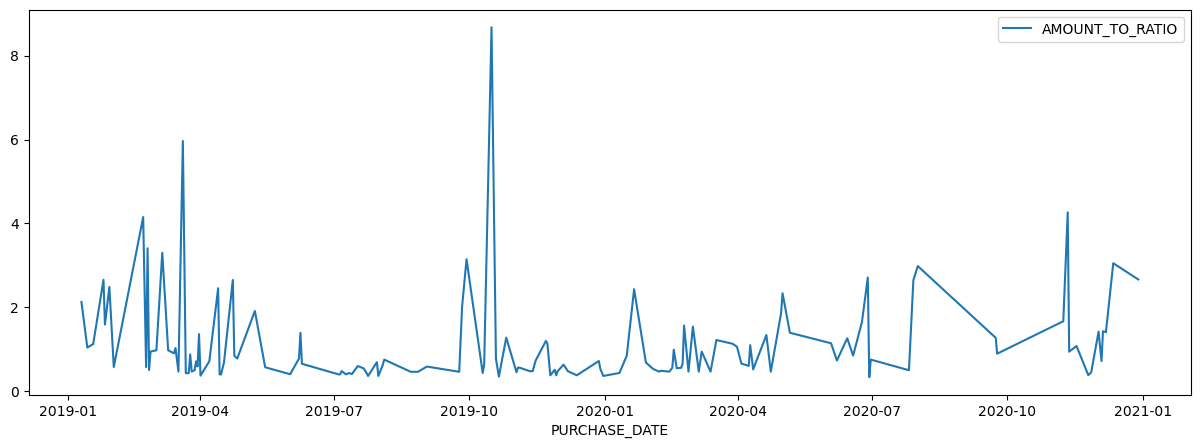

In [20]:
import snowflake.snowpark.functions as F
import pandas as pb
from matplotlib import pyplot


pd.DataFrame(
    df_ml.select(
        F.col('PURCHASE_DATE'),
        F.col('AMOUNT_TO_RATIO')
    ).collect()
).set_index(
    'PURCHASE_DATE'
).plot(
    figsize=(15,5)
)
# もしくは
# df.select(
#     F.col('PURCHASE_DATE'),
#     F.col('AMOUNT_TO_RATIO')
# ).to_pandas().set_index(
#     'PURCHASE_DATE'
# ).plot(
#     figsize=(15,5)
# )

事前にデータセットをトレーニング用/評価用に分けます。
今回は、

- トレーニング用： 2020-01-01 ～ 2020-09-30
- 評価用：2020-10-01～

と分割します。

In [21]:
train_table_name = 'DF_ML_TRAIN'
test_table_name = 'DF_ML_TEST'

In [22]:
import snowflake.snowpark.types as T


df_ml_train = df_ml.where(
    (F.col('PURCHASE_DATE') >= '2020-01-01')
    & (F.col('PURCHASE_DATE') <= '2020-09-30')
)
df_ml_test = df_ml.where(
    F.col('PURCHASE_DATE') >= '2020-10-01'
)

df_ml_train.write.mode("overwrite").save_as_table(train_table_name, table_type="temporary")
df_ml_test.write.mode("overwrite").save_as_table(test_table_name, table_type="temporary")

<Axes: xlabel='PURCHASE_DATE'>

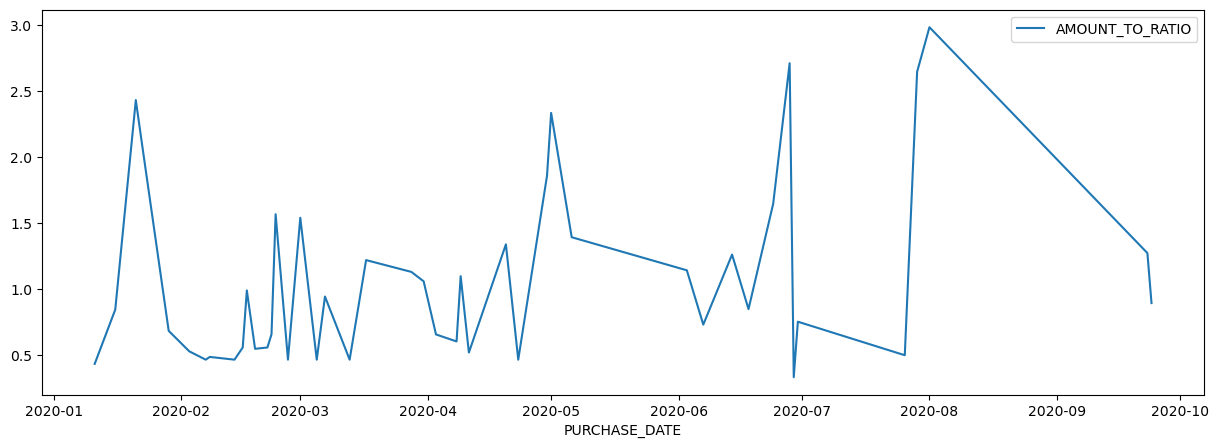

In [23]:
pd.DataFrame(
    df_ml_train.select(
        F.col('PURCHASE_DATE'),
        F.col('AMOUNT_TO_RATIO')
    ).collect()
).set_index(
    'PURCHASE_DATE'
).plot(
    figsize=(15,5)
)

<Axes: xlabel='PURCHASE_DATE'>

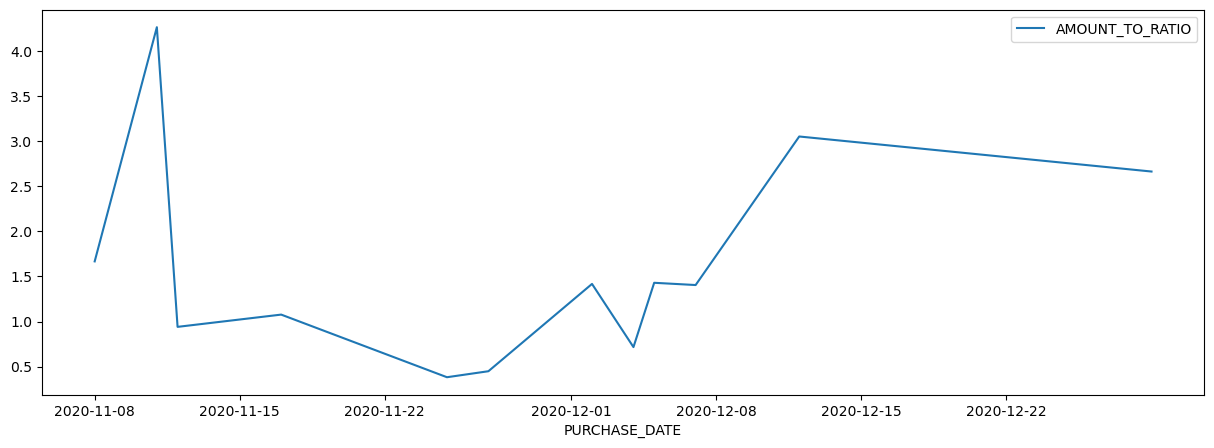

In [24]:
pd.DataFrame(
    df_ml_test.select(
        F.col('PURCHASE_DATE'),
        F.col('AMOUNT_TO_RATIO')
    ).collect()
).set_index(
    'PURCHASE_DATE'
).plot(
    figsize=(15,5)
)

### 学習とモデルの保存


学習を実行してみましょう。
今回は、ストアドプロシージャで学習の実行と学習済みモデルの保存を行います。

学習を実行する際、集計や変換などの処理より大きなメモリが必要な場合があります。その場合は Snowpark 最適化インスタンスを使うとよいでしょう。

必要なパッケージがいくつかあるので、インストールします。[`install_packages`](./install_packages) で使用するパッケージをインストールできます。 

In [25]:
# notebook 上でインストール時コマンドを実行することもできます
# !conda install numpy==1.23.5 pandas==1.5.3 cachetools==4.2.2 dill==0.3.6 matplotlib==3.7.1 seaborn==0.12.2


モデル保存用のステージを作成します。

In [26]:
model_stage_name = 'model_stage'
session.sql(f'create or replace stage "{model_stage_name}";').collect()

[Row(status='Stage area model_stage successfully created.')]

In [27]:
%%time

import snowflake.snowpark
from snowflake.snowpark import FileOperation
from snowflake.snowpark.functions import sproc
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T

import io
import dill

from xgboost import XGBRegressor
import pandas as pd


def save_file(
            session: snowflake.snowpark.Session, 
            model, 
            path: str
        ) -> str:
    ''' model を session で接続している環境の path に保存する'''
    input_stream = io.BytesIO()
    dill.dump(model, input_stream)
    try:
        session._conn._cursor.upload_stream(input_stream, path)
        msg = "successfully created file: " + path
    except Exception as e:
        msg = f'upload stream no exists. ({e})'
    
    return msg


def train_xgboost_model(
        session: Session, 
        training_table: str,
        feature_cols: list,
        target_col: str,
        model_name: str) -> T.Variant:
    # 対象データを取得
    local_training_data = session.table(training_table).to_pandas()
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]

    # 学習
    xgbmodel = XGBRegressor(random_state=123)
    xgbmodel.fit(X,y)
 
    # 特徴量重要度を取得
    feat_importance = pd.DataFrame(xgbmodel.feature_importances_,feature_cols,columns=['FeatImportance']).to_dict()

    # モデルを内部ステージに保存
    print(save_file(session, xgbmodel, f'@"{model_stage_name}"/{model_name}'))

    return feat_importance

CPU times: user 346 ms, sys: 8.11 ms, total: 354 ms
Wall time: 354 ms


ストアドプロシージャを登録し、実行しましょう。
先ほどはデコレータ `@register()` を使用しましたが、ここでは `register()` を使用します。


In [28]:
train_xgboost_model_sproc = session.sproc.register(
    train_xgboost_model,
    stage_location=f'@"{model_stage_name}"',
    packages=['snowflake-snowpark-python', 'xgboost', 'pandas', 'dill'],
    replace=True
)

The version of package pandas in the local environment is 2.0.0, which does not fit the criteria for the requirement pandas. Your UDF might not work when the package version is different between the server and your local environment


In [29]:
model_name = 'xgboost_model.sav'

feature_cols = df_ml_train.columns
target_col = 'AMOUNT_TO_RATIO'
feature_cols.remove(target_col)
feature_cols.remove('PURCHASE_DATE')

feat_importance = train_xgboost_model_sproc(
    train_table_name, 
    feature_cols,
    target_col,
    model_name, 
    session=session
)

print(feat_importance)

{
  "FeatImportance": {
    "MOVING_1WEEK_AMOUNT_TO_RATIO_AVG": 0.24668481945991516,
    "MOVING_3DAY_AMOUNT_TO_RATIO_AVG": 0.7533152103424072
  }
}


### 推論

推論を実行します。
UDF を作成して、Snowflake にあるテーブルに対して推論を実行し、結果を Snowflake テーブルに保存します。


In [30]:
%%time

import sys
import cachetools
import os
import dill
from snowflake.snowpark.functions import udf


# cachetools というおまじないについては https://docs.snowflake.com/developer-guide/snowpark/reference/python/api/snowflake.snowpark.udf.UDFRegistration.html Example 8 をご参照ください
@cachetools.cached(cache={})
def load_from_snowflake_import_dir(filename):
    '''指定したモデルファイルを読み込む。
    対象ファイルがインポートされているか、対象ファイルが存在するステージが stage_location に指定されていることが必要'''
    import_dir = sys._xoptions.get('snowflake_import_directory')
    with open(os.path.join(import_dir, filename), 'rb') as file:
        m = dill.load(file)
        return m

def predict(args: list) -> float:
    model = load_from_snowflake_import_dir(model_name)
    row = pd.DataFrame(
        [args],
        columns=feature_cols
    )
    return model.predict(row)


CPU times: user 5.32 ms, sys: 470 µs, total: 5.79 ms
Wall time: 3.6 ms


予測を実行してみましょう！

In [31]:
%%time

predict_xgboost_regression_udf = session.udf.register(
    func=predict,
    name='predict_xgboost_regression_udf',
    stage_location=f'@"{model_stage_name}"',
    return_type = T.FloatType(),
    replace=True,
    is_permanent=True,
    imports=[f'@"{model_stage_name}"/{model_name}'],
    packages=['pandas', 'xgboost', 'cachetools', 'dill'],
    session=session
)

pred_table_name = 'DF_ML_PRED'
df_ml_test.select(
    F.col('PURCHASE_DATE'),
    F.col(target_col),
    F.call_udf(
        "predict_xgboost_regression_udf", 
        F.array_construct(*feature_cols)).alias(f'PREDICTED_{target_col}'
    )
).write.mode('overwrite').saveAsTable(pred_table_name)


The version of package pandas in the local environment is 2.0.0, which does not fit the criteria for the requirement pandas. Your UDF might not work when the package version is different between the server and your local environment


CPU times: user 65.8 ms, sys: 1.1 ms, total: 66.8 ms
Wall time: 12.8 s


予測結果を確認してみましょう。


<Axes: xlabel='PURCHASE_DATE'>

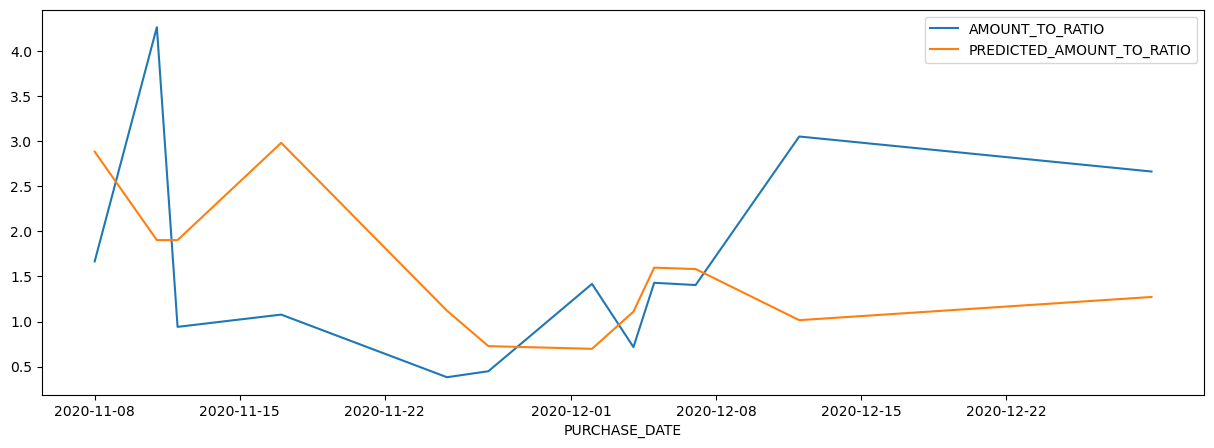

In [32]:
pdf_score = session.table(pred_table_name)

pd.DataFrame(
    pdf_score.collect()
).set_index(
    'PURCHASE_DATE'
).plot(
    figsize=(15,5)
)


全然じゃないか（呆れ）

雑にモデルを作るとこうなりますが、参加者の皆さまにおかれましては、データをよく見て有用なモデルを作成頂ければと思います。


## 提供データを Snowpark で触ってみよう


先ほどのデータコラボレーションのお話では、データの組み合わせについて、たくさんのアイデアが紹介されていましたね。

ここまでのデモンストレーションをご覧になった皆様なら、もうご自身で、様々なデータ処理ができるのではないでしょうか？

最後に、デモで少し扱ったフードデリバリーデータとカレンダーデータを合わせて、データの操作と可視化を行ってみます。  
カレンダーだけでも、曜日ごとの傾向や祝日の影響など、さまざまな分析ができそうですね。

In [33]:
df_dely = session.table('MINEDIA_CONTEST.CONTEST.PURCHASE_DELIVERY')
df_calender = session.table("PODB__JAPANESE_OPEN_DATA_SAMPLE_DATASETS.CALENDAR.E_JAPAN_CALENDAR")

df = df_dely.join(  # カレンダー情報をinner joinで付与
    df_calender,
    df_dely.PURCHASE_DATE == df_calender.DATE,
    join_type = 'inner'
).select(
    F.col('PURCHASE_DATE'), F.col('PURCHASE_AREA'), F.col('AMOUNT_TO_RATIO'), F.col('WEEKDAY'), F.col('HOLIDAY_NAME')
)

df.sort(
    F.col('AMOUNT_TO_RATIO'),  # 推定購入値の降順で並べ替え
    ascending = False
).limit(10).show()



--------------------------------------------------------------------------------------
|"PURCHASE_DATE"  |"PURCHASE_AREA"  |"AMOUNT_TO_RATIO"  |"WEEKDAY"  |"HOLIDAY_NAME"  |
--------------------------------------------------------------------------------------
|2019-04-03       |江東区              |21.876841467469    |水          |NULL            |
|2020-05-31       |江東区              |20.705273021596    |日          |NULL            |
|2020-08-19       |世田谷区             |14.076044622282    |水          |NULL            |
|2019-12-16       |世田谷区             |12.410324289843    |月          |NULL            |
|2020-09-22       |江東区              |12.361275572344    |火          |秋分の日            |
|2020-10-09       |葛飾区              |11.256848859906    |金          |NULL            |
|2020-11-29       |中央区              |10.806918631905    |日          |NULL            |
|2020-12-04       |豊島区              |10.467979482047    |金          |NULL            |
|2020-04-20       |世田谷区             |9.3926

<Axes: xlabel='WEEKDAY', ylabel='AMOUNT_TO_RATIO_AVG'>

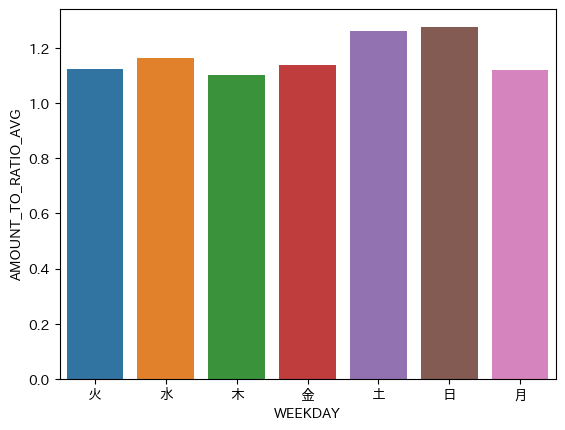

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib


pdf = pd.DataFrame(
    df.group_by(
        F.col('WEEKDAY')
    ).agg(
        F.avg(F.col('AMOUNT_TO_RATIO')).name('AMOUNT_TO_RATIO_AVG')
    ).collect()
)
sns.barplot(x = 'WEEKDAY', y = 'AMOUNT_TO_RATIO_AVG', data = pdf)

曜日ごとの平均に、そこまで差はないように見受けられます。では、港区に絞ってみるとどうでしょう？

<Axes: xlabel='WEEKDAY', ylabel='AMOUNT_TO_RATIO_AVG'>

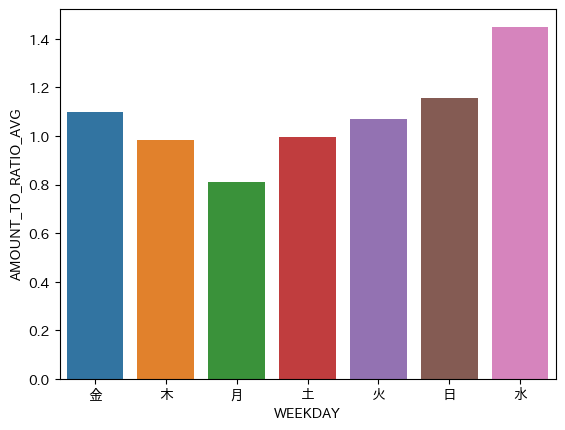

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt


pdf = pd.DataFrame(
    df.where(
        F.col('PURCHASE_AREA') == '港区'
    ).group_by(
        F.col('WEEKDAY')
    ).agg(
        F.avg(F.col('AMOUNT_TO_RATIO')).name('AMOUNT_TO_RATIO_AVG')
    ).collect()
)
sns.barplot(x = 'WEEKDAY', y = 'AMOUNT_TO_RATIO_AVG', data = pdf)


月曜が低く、水曜が突出しているように見えますね。水曜日に一体何があるのか、もっとデータを眺めてみると、何かわかるかもしれませんね。

地域×曜日 の組み合わせ以外にも、様々な組み合わせで集計と可視化を行って、データを深掘りしてみてください！